#VI-EN Machine Translation
#Compare Beam Search
**Dataset: IWSLT15-en-vi**

**khuongvd00@gmail.com**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/NLP/machine_translation

In [ ]:
!pip install -q transformers==4.26.1 sentencepiece==0.1.97 datasets==2.9.0 sacrebleu==2.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np

import sacrebleu

import sentencepiece

import torch
from torch.utils.data import Dataset

from datasets import load_dataset, load_metric
from transformers import *

In [ ]:
class BaseConfig:
    """ base Encoder Decoder config """

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

class NMTConfig(BaseConfig):
    # Data
    src_lang = 'vi'
    tgt_lang = 'en'
    max_len = 100

    # Model
    model_name = "facebook/mbart-large-50-many-to-many-mmt"

    # Training
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    learning_rate = 5e-5
    train_batch_size = 32
    eval_batch_size = 32
    num_train_epochs = 3
    ckpt_dir = model_name.split('/')[1]
    eval_steps = 500

    # Inference
    beam_size = 5

cfg = NMTConfig()

In [ ]:
def load_model(cfg, checkpoint_name):
    # Load Tokenizer
    tokenizer = MBart50TokenizerFast.from_pretrained(cfg.model_name, src_lang="vi_VN",tgt_lang = "en_XX")

    # Load Model
    model_save_path = f"{cfg.ckpt_dir}/{checkpoint_name}"
    model = MBartForConditionalGeneration.from_pretrained(model_save_path)

    # Inference Param
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    return tokenizer, model, device

In [ ]:
from tqdm import tqdm
def inference(
    text, 
    src_tokenizer, 
    tgt_tokenizer, 
    model, 
    device="cpu", 
    max_length=75,
    beam_size=5
    ):
    inputs = src_tokenizer(
        text, 
        padding="max_length", 
        truncation=True, 
        max_length=max_length, 
        return_tensors="pt"
        )
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    model.to(device)

    outputs = model.generate(
        input_ids, 
        attention_mask=attention_mask, 
        max_length=max_length, 
        early_stopping=True, 
        num_beams=beam_size, 
        length_penalty=2.0
    )

    output_str = tgt_tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return output_str

def inference_bath(
    texts, 
    tokenizer, 
    model, 
    device="cpu", 
    max_length=50,
    beam_size=5,
    batch_size=32
    ):

    pred_texts = []

    if len(texts) < batch_size:
        batch_size = len(texts)

    for x in tqdm(range(0, len(texts), batch_size)):
        text = texts[x:x+batch_size]

        inputs = tokenizer(
            text, 
            padding="max_length", 
            truncation=True, 
            max_length=max_length, 
            return_tensors="pt"
            )
        
        input_ids = inputs.input_ids.to(device)
        attention_mask = inputs.attention_mask.to(device)
        model.to(device)

        outputs = model.generate(
            input_ids, 
            attention_mask=attention_mask, 
            max_length=max_length, 
            early_stopping=True, 
            num_beams=beam_size, 
            length_penalty=2.0
        )

        output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        pred_texts.extend(output_str)
        torch.cuda.empty_cache()

    return pred_texts

In [ ]:
data = load_dataset("mt_eng_vietnamese", "iwslt2015-en-vi", split="test")
src_texts = [sample["translation"]["vi"] for sample in data]
tgt_texts = [sample["translation"]["en"] for sample in data]

In [ ]:
save_pred_path = f"beam_size_report/test_en.txt"
with open(save_pred_path, 'w') as f:
    for text in tgt_texts:
        f.write(text + "\n")

In [ ]:
def compare_beam_size(beam_size):
    save_pred_path = f"beam_search/mbart50-checkpoint-3500_beam_size_{beam_size}.txt"
    pred_texts = inference_bath(src_texts, tokenizer, model, device, beam_size=beam_size) 
    with open(save_pred_path, 'w') as f:
        for text in pred_texts:
            f.write(text + "\n")
    return sacrebleu.corpus_bleu(pred_texts, [tgt_texts])

bleu_scores = {}
for i in range(1, 21):
    beam_size = i
    bleu_score = compare_beam_size(beam_size)
    bleu_scores[i] = bleu_score

bleu_scores

In [ ]:
[round(a.score, 2) for a in list(bleu_scores.values())]

[32.69,
 33.49,
 33.87,
 33.91,
 34.07,
 34.16,
 34.34,
 34.33,
 34.35,
 34.41,
 34.35,
 34.39,
 34.37,
 34.28,
 34.18,
 34.14,
 34.23,
 34.21,
 34.27,
 34.28]

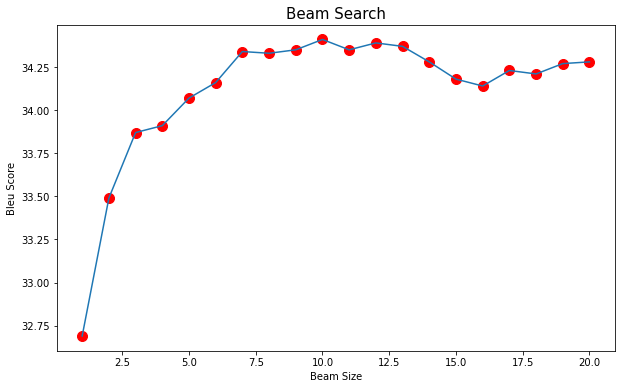

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X=list(bleu_scores.keys())
Y=[round(a.score, 2) for a in list(bleu_scores.values())]

annotations=[round(a.score, 2) for a in list(bleu_scores.values())]

plt.figure(figsize=(10,6))
plt.scatter(X,Y,s=100,color="red")
plt.xlabel("Beam Size")
plt.ylabel("Bleu Score")
plt.title("Beam Search",fontsize=15)
# for i, label in enumerate(annotations):
#     plt.annotate(label, (X[i], Y[i]))

plt.plot(X, Y)
plt.show()